In [660]:
import pandas as pd
import numpy as np
from vnstock import *
from datetime import datetime, timedelta
from dateutil.parser import parse
from dateutil.relativedelta import relativedelta

In [661]:
path = 'C:/Users/atlas/OneDrive/Desktop/vnstock'

In [662]:
#daily_price = pd.read_csv(path + '/daily_price.csv')
yearly_price = pd.read_csv(path + '/yearly_price.csv')
df = pd.read_csv(path + '/df10.csv')

In [663]:
# Initialize an empty list to store the results
top_tickers_df_append = []

# Finding the top ticker for each time point
for x in range(1, 32):  # Loop from 1 to 3 as per your requirement
    top_tickers_df = pd.DataFrame(columns=['time', 'Ranking', 'Top Ticker', 'x'])

    for col in range(1, x):
        max_ticker_idx = df.groupby('time')[str(col)].idxmax()
        max_ticker = df.loc[max_ticker_idx]
        max_ticker['Ranking'] = f'ranking{col}'  # Adjust ranking label based on column
        max_ticker.rename(columns={'Ticker': 'Top Ticker', 'time': 'time'}, inplace=True)
        max_ticker['x'] = col  # Assign the value of x dynamically
        top_tickers_df = pd.concat([top_tickers_df, max_ticker[['time', 'Ranking', 'Top Ticker', 'x']]], ignore_index=True)

    # Convert 'time' column in top_tickers_df to datetime64[ns]
    top_tickers_df['time'] = pd.to_datetime(top_tickers_df['time'])

    # Create the new column "x_final" to get the max value of "x"
    top_tickers_df['x_final'] = top_tickers_df['x'].max()

    # Append the DataFrame to the list
    top_tickers_df_append.append(top_tickers_df)

# Concatenate all DataFrames in the list
top_tickers = pd.concat(top_tickers_df_append, ignore_index=True)

In [664]:
yearly_price['time'] = pd.to_datetime(yearly_price['time'])
top_tickers = pd.merge(top_tickers, yearly_price[['time','ticker','next date']], left_on=['time', 'Top Ticker'], right_on=['time', 'ticker'], how='left')
top_tickers.drop(columns=['ticker'], inplace=True)
top_tickers.rename(columns ={'next date':'buying date'}, inplace = True)
top_tickers['buying date'] = pd.to_datetime(top_tickers['buying date'])

In [665]:
final = pd.merge(top_tickers, yearly_price, left_on=['buying date', 'Top Ticker'], right_on=['time', 'ticker'], how='left')
final['year'] = final['buying date'].dt.year

In [666]:
final.head()

,time_x,Ranking,Top Ticker,x,x_final,buying date,time_y,ticker,close,year,next year price,return,next date
0,2012-12-28,ranking1,HNG,1,1.0,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-12-31,ranking1,LSS,1,1.0,2014-12-31,2014-12-31,LSS,6760.0,2014.0,6410.0,-0.051775,2015-12-31
2,2014-12-31,ranking1,LGC,1,1.0,2015-12-31,2015-12-31,LGC,19480.0,2015.0,21180.0,0.087269,2016-12-30
3,2015-12-31,ranking1,ASP,1,1.0,2016-12-30,2016-12-30,ASP,2670.0,2016.0,4980.0,0.865169,2017-12-29
4,2016-12-30,ranking1,DRH,1,1.0,2017-12-29,2017-12-29,DRH,12356.0,2017.0,7856.0,-0.364196,2018-12-28


In [667]:
output = pd.pivot_table(data=final, values="return", index="x_final", columns='year', aggfunc='mean', fill_value=0)
output.reset_index(drop=False, inplace=True)  # Reset index
avg_annual_return = output.iloc[:, 1:-1].mean(axis=1)
output['avg_annual_return'] = avg_annual_return
output = output.sort_values(by='avg_annual_return', ascending=False)

In [668]:
#To create the maximum avg annual return:
# Find the index of the row with maximum avg_annual_return
max_index = output['avg_annual_return'].idxmax()
x_final_max_return = output.loc[max_index, 'x_final']
print(x_final_max_return)

con4 = output ['x_final'] == x_final_max_return
max_output = output[con4]

#delete the last col
max_output = max_output.iloc[:, :-1]

#delete the first col
max_output = max_output.iloc[:, 1:]
max_output = max_output.T
max_output.reset_index(drop=False, inplace=True)  # Reset index

max_output = max_output.rename(columns={max_output.columns[1]: 'avg_return_model'})
max_output['year'] = max_output['year'].astype(int)
max_output.head()

2.0


,year,avg_return_model
0,2013,1.521505
1,2014,0.032738
2,2015,0.401537
3,2016,0.667878
4,2017,-0.159147


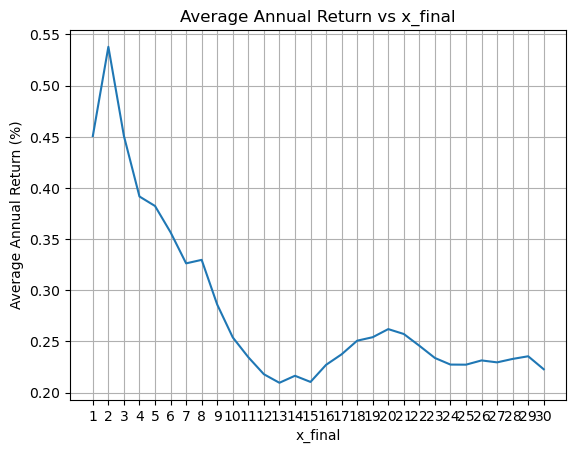

In [669]:
import matplotlib.pyplot as plt

# Remove '%' sign and convert to float
output['avg_annual_return'] = output['avg_annual_return'].apply(lambda x: float(x.strip('%')) if isinstance(x, str) else x)

# Sort DataFrame by "x_final"
output_sorted = output.sort_values(by='x_final')

# Plot the line chart
plt.plot(output_sorted['x_final'], output_sorted['avg_annual_return'])
plt.xlabel('x_final')
plt.ylabel('Average Annual Return (%)')
plt.title('Average Annual Return vs x_final')
plt.grid(True)  # Add grid lines

# Set x-axis ticks with steps of 1
plt.xticks(range(int(output_sorted['x_final'].min()), int(output_sorted['x_final'].max()) + 1, 1))

plt.show()


In [670]:
# Group the data by year and calculate the mean return for each year
avg_return_market = yearly_price.groupby('year')['return'].mean().reset_index()

# Rename the columns for clarity
avg_return_market.columns = ['year', 'avg_return_market']
avg_return_market.head(2)

,year,avg_return_market
0,2012,0.414324
1,2013,0.447607


In [671]:
return_comparison = pd.merge(max_output, avg_return_market, left_on=['year'], right_on=['year'], how='left')

In [672]:
current_year = pd.Timestamp.now().year  # Get the current year

# Create the gap_year column
return_comparison['gap_year'] = current_year - return_comparison['year']

In [673]:
return_comparison.head(2)

,year,avg_return_model,avg_return_market,gap_year
0,2013,1.521505,0.447607,11
1,2014,0.032738,0.235000,10


In [674]:
import pandas as pd

# Calculate cumulative sum and count of close prices for all history
yearly_price['cumulative_sum_all'] = yearly_price.groupby('ticker')['close'].transform(lambda x: x.cumsum() - x)
yearly_price['cumulative_count_all'] = yearly_price.groupby('ticker').cumcount()

# Calculate cumulative sum and count of close prices for the last 3 years
yearly_price['cumulative_sum_3years'] = yearly_price.groupby('ticker')['close'].transform(lambda x: x.rolling(window=4, min_periods=1).sum() - x)
yearly_price['cumulative_count_3years'] = yearly_price.groupby('ticker')['close'].transform(lambda x: x.rolling(window=4, min_periods=1).count() - 1)

# Calculate average close price for all history and last 3 years
yearly_price['avg_price_all_history'] = yearly_price['cumulative_sum_all'] / yearly_price['cumulative_count_all']
yearly_price['avg_price_3years'] = yearly_price['cumulative_sum_3years'] / yearly_price['cumulative_count_3years']

# Drop unnecessary columns
yearly_price.drop(columns=['cumulative_sum_all', 'cumulative_count_all', 'cumulative_sum_3years', 'cumulative_count_3years'], inplace=True)

# Group by year and ticker, then take the last entry (which is the highest year) for each ticker
new_df = yearly_price.groupby(['ticker', 'year']).last().reset_index()
new_df.head(3)


,ticker,year,time,close,next year price,return,next date,avg_price_all_history,avg_price_3years
0,AAA,2012,2012-12-28,3845,5237.0,0.362029,2013-12-31,NaN,NaN
1,AAA,2013,2013-12-31,5237,5647.0,0.078289,2014-12-31,3845.0,3845.0
2,AAA,2014,2014-12-31,5647,6270.0,0.110324,2015-12-31,4541.0,4541.0


In [675]:
con5 = final['x_final'] == x_final_max_return
stock_watch = final[con5]
stock_watch = stock_watch[['x_final','ticker','buying date','next date','close','next year price','return','year']]
stock_watch = stock_watch.sort_values(by='buying date', ascending=False)
stock_watch['return'] = (stock_watch['return'] * 100).map('{:.2f}%'.format)
#stock_watch = pd.merge(stock_watch, new_df[['ticker','year','avg_price_all_history','avg_price_3years']], left_on=['year', 'ticker'], right_on=['year', 'ticker'], how='left')
stock_watch.rename(columns={'close': 'buying price', 'next date': 'selling date', 'next year price': 'selling price'}, inplace=True)
stock_watch[stock_watch['year'] == 2023]

,x_final,ticker,buying date,selling date,buying price,selling price,return,year
111,2.0,LBM,2023-12-29,2024-04-17,46350.0,41800.0,-9.82%,2023.0
69,2.0,TPC,2023-12-28,2024-04-17,5800.0,5630.0,-2.93%,2023.0


In [676]:

# Create a new DataFrame with the first column unchanged and the rest converted to percentages
output.iloc[:, 1:] = output.iloc[:, 1:].apply(lambda x: x.map(lambda val: f"{val * 100:.1f}%"))
output


year,x_final,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,avg_annual_return
1,2.0,152.2%,3.3%,40.2%,66.8%,-15.9%,-11.1%,26.2%,267.2%,-16.8%,26.0%,-6.4%,53.8%
2,3.0,90.9%,3.3%,35.4%,45.1%,-15.9%,-6.8%,35.6%,249.2%,-15.0%,29.0%,0.3%,45.1%
0,1.0,0.0%,-5.2%,8.7%,86.5%,-36.4%,0.0%,15.3%,356.0%,4.4%,21.4%,-2.9%,45.1%
3,4.0,85.7%,7.8%,35.4%,58.9%,-5.9%,-5.4%,21.5%,197.8%,-26.2%,22.1%,-6.2%,39.2%
4,5.0,85.7%,9.6%,9.5%,68.0%,-5.9%,-5.9%,30.3%,162.7%,-20.3%,48.6%,-1.6%,38.2%
5,6.0,85.7%,21.1%,9.5%,68.0%,-5.9%,-8.0%,30.3%,141.1%,-29.7%,44.5%,-1.4%,35.7%
7,8.0,85.7%,21.1%,8.3%,59.2%,0.2%,-10.4%,38.8%,127.0%,-38.1%,38.0%,-0.4%,33.0%
6,7.0,85.7%,21.1%,9.5%,56.0%,-3.4%,-6.2%,27.3%,128.0%,-33.5%,42.0%,-1.5%,32.6%
8,9.0,61.2%,26.5%,9.8%,57.3%,-2.7%,-12.0%,34.7%,114.5%,-35.9%,32.7%,-0.3%,28.6%
19,20.0,47.1%,17.9%,12.9%,43.7%,4.6%,-4.0%,34.1%,115.8%,-39.2%,29.2%,-1.0%,26.2%


In [680]:

# write df to csv file and open it.
csv_file_path = 'C:/Users/atlas/OneDrive/Desktop/vnstock/output.csv'
output.to_csv(csv_file_path, index=False)
# Open the CSV file
os.startfile(csv_file_path)

In [677]:
# Assuming return_comparison is your DataFrame
# Calculate the averages based on the conditions
avg_return_model_condition = return_comparison[return_comparison['gap_year'] >= 2]['avg_return_model'].mean()
avg_return_market_condition = return_comparison[return_comparison['gap_year'] >= 2]['avg_return_market'].mean()

# Create a new DataFrame with the calculated averages
new_df = pd.DataFrame({
    'avg_return_model_condition': [avg_return_model_condition],
    'avg_return_market_condition': [avg_return_market_condition]
})

new_df

,avg_return_model_condition,avg_return_market_condition
0,0.537875,0.254086


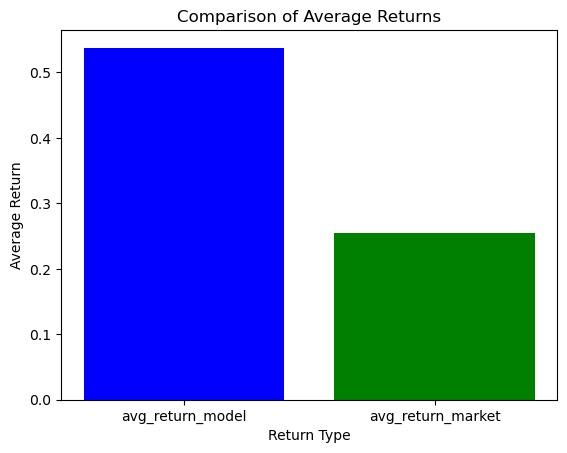

In [678]:
import matplotlib.pyplot as plt

# Calculate the averages based on the conditions
avg_return_model_condition = return_comparison[return_comparison['gap_year'] >= 2]['avg_return_model'].mean()
avg_return_market_condition = return_comparison[return_comparison['gap_year'] >= 2]['avg_return_market'].mean()

# Create a bar chart
labels = ['avg_return_model', 'avg_return_market']
values = [avg_return_model_condition, avg_return_market_condition]

plt.bar(labels, values, color=['blue', 'green'])
plt.xlabel('Return Type')
plt.ylabel('Average Return')
plt.title('Comparison of Average Returns')
plt.show()


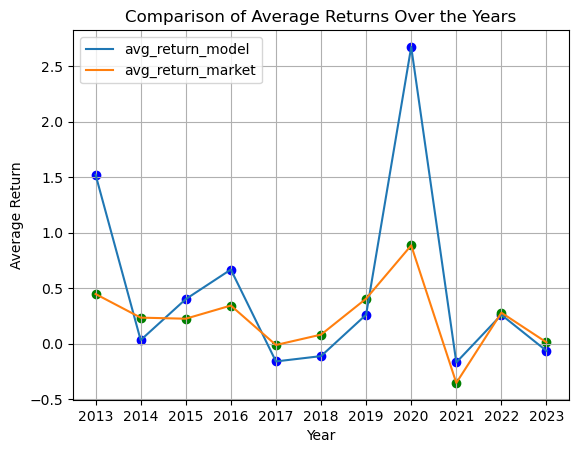

In [679]:
import matplotlib.pyplot as plt

# Assuming return_comparison is your DataFrame

# Sort DataFrame by year
return_comparison_sorted = return_comparison.sort_values(by='year')

# Plot the line chart
plt.plot(return_comparison_sorted['year'], return_comparison_sorted['avg_return_model'], label='avg_return_model')
plt.plot(return_comparison_sorted['year'], return_comparison_sorted['avg_return_market'], label='avg_return_market')

# Add data points
plt.scatter(return_comparison_sorted['year'], return_comparison_sorted['avg_return_model'], color='blue')
plt.scatter(return_comparison_sorted['year'], return_comparison_sorted['avg_return_market'], color='green')

# Add grid lines behind the chart
plt.grid(True, zorder=0)

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Average Return')
plt.title('Comparison of Average Returns Over the Years')

# Set x-axis ticks with steps of 1 year
plt.xticks(return_comparison_sorted['year'])

# Add legend
plt.legend()

# Show plot
plt.show()
